# Model Sistem Rekomendasi Anime

* Nama : Annisa Dewiyanti
* ID Dicoding : andwynt
* Dataset: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database
* Domain : Rekomendasi Fim Annimasi (*Anime*)

# 1. Data Understanding

## Import Library

In [1]:
import zipfile
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import EarlyStopping
from google.colab import files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Download Dataset

In [2]:
!pip install -q kaggle

In [3]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!chmod 600 /content/kaggle.json
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d CooperUnion/anime-recommendations-database

Dataset URL: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database
License(s): CC0-1.0
  0% 0.00/25.0M [00:00<?, ?B/s]
100% 25.0M/25.0M [00:00<00:00, 683MB/s]


In [5]:
local_zip = '/content/anime-recommendations-database.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

dalam folder anime-recommendations-database.zip terdapat dua file yang dibutuhkan

1. anime.csv
2. rating.csv

In [6]:
anime = pd.read_csv("/content/anime.csv")
ratings = pd.read_csv("/content/rating.csv")

print(f'Jumlah data anime: {anime.shape[0]}')
print(f'Jumlah variabel pada data anime: {anime.shape[1]} variabel')
print(f'Jumlah data ratings: {ratings.shape[0]}')
print(f'Jumlah variabel pada data ratings: {ratings.shape[1]} variabel')

Jumlah data anime: 12294
Jumlah variabel pada data anime: 7 variabel
Jumlah data ratings: 7813737
Jumlah variabel pada data ratings: 3 variabel


# Data Understanding

* Dataset Anime

In [7]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Variable dataset movies terbagi 3 yakni:

* anime_id -> ID anime
* name -> Judul anime
* genres -> Genre anime
* type -> Tipe anime
* episodes -> Episode anime
* rating -> Nilai dari anime
* members -> jumlah komunitas dari anime tersebut

In [8]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [9]:
print(f'Cek Duplikasi Dataset Anime: {anime.duplicated().sum()} duplikasi')

Cek Duplikasi Dataset Anime: 0 duplikasi


In [10]:
print(f'Cek Missing Value Pada Variable Dataset Anime:')
print(f'- anime_id sebanyak {anime.anime_id.isnull().sum()}')
print(f'- name sebanyak {anime.name.isnull().sum()}')
print(f'- genre sebanyak {anime.genre.isnull().sum()}')
print(f'- type sebanyak {anime.type.isnull().sum()}')
print(f'- episodes sebanyak {anime.episodes.isnull().sum()}')
print(f'- rating sebanyak {anime.rating.isnull().sum()}')
print(f'- members sebanyak {anime.members.isnull().sum()}')

Cek Missing Value Pada Variable Dataset Anime:
- anime_id sebanyak 0
- name sebanyak 0
- genre sebanyak 62
- type sebanyak 25
- episodes sebanyak 0
- rating sebanyak 230
- members sebanyak 0


* Dataset Ratings

In [11]:
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


**insight**

Variable dataset ratings terbagi 3 yaitu:

* **user_id**-> ID User pemberi rating
* **anime_id** -> ID film yang dirating
* **rating** -> Rating film yang diberikan user

In [12]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [13]:
ratings.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


**insight**

setelah dicek, didapatkan informasi skala dari rating film yakni rating  -1 dan rating tertinggi adalah 10.

In [14]:
print(f'Cek Missing Value Pada Variable Dataset Rating:')
print(f'- user_id sebanyak {ratings.user_id.isnull().sum()}')
print(f'- anime_id sebanyak {ratings.anime_id.isnull().sum()}')
print(f'- rating sebanyak {ratings.rating.isnull().sum()}')

Cek Missing Value Pada Variable Dataset Rating:
- user_id sebanyak 0
- anime_id sebanyak 0
- rating sebanyak 0


In [15]:
print(f'Cek Duplikasi Dataset Ratings: {ratings.duplicated().sum()} duplikasi')

Cek Duplikasi Dataset Ratings: 1 duplikasi


# 2. Data Preparation

## Sorting Data Rating Berdasarkan User ID Kemudian Menjadikan integer

In [16]:
ratings = ratings.sort_values('user_id').astype('int')

## Pembersihan Missing Value

* Menghapus missing value pada dataset anime.

In [17]:
anime.isna().sum()

,0
anime_id,0
name,0
genre,62
type,25
episodes,0
rating,230
members,0


In [18]:
anime = anime.dropna()

In [19]:
anime.isna().sum()

,0
anime_id,0
name,0
genre,0
type,0
episodes,0
rating,0
members,0


## Menghapus symbol pada judul anime

In [20]:
import re
def text_cleaning(text):
    text = re.sub(r'"', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'\'', '', text)
    text = re.sub(r'A\'s', '', text)
    text = re.sub(r'I\'', 'I\'', text)
    text = re.sub(r'&', 'and', text)

    return text

anime.loc[:, 'name'] = anime['name'].apply(text_cleaning)

## Pembersihan Duplikasi Data

In [21]:
ratings.drop_duplicates(subset=['user_id','anime_id'], keep='first', inplace=True)

##Penggabungan Dataset

In [22]:
merge_dataset = pd.merge(ratings, anime, how='left', on='anime_id')
animerating = merge_dataset.copy()
animerating.head()

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
0,1,936,-1,Naruto Movie 2: Dai Gekitotsu! Maboroshi no Ch...,"Adventure, Comedy, Drama, Fantasy, Shounen, Su...",Movie,1,6.99,97308.0
1,1,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0
2,1,4744,-1,Akaneiro ni Somaru Saka,"Comedy, Harem, Romance, School",TV,12,6.69,91453.0
3,1,4581,-1,Shikabane Hime: Aka,"Action, Horror, Martial Arts",TV,13,7.38,71502.0
4,1,4224,-1,Toradora!,"Comedy, Romance, School, Slice of Life",TV,25,8.45,633817.0


In [23]:
animerating = animerating.drop('rating_x', axis=1)
animerating.head()

,user_id,anime_id,name,genre,type,episodes,rating_y,members
0,1,936,Naruto Movie 2: Dai Gekitotsu! Maboroshi no Ch...,"Adventure, Comedy, Drama, Fantasy, Shounen, Su...",Movie,1,6.99,97308.0
1,1,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0
2,1,4744,Akaneiro ni Somaru Saka,"Comedy, Harem, Romance, School",TV,12,6.69,91453.0
3,1,4581,Shikabane Hime: Aka,"Action, Horror, Martial Arts",TV,13,7.38,71502.0
4,1,4224,Toradora!,"Comedy, Romance, School, Slice of Life",TV,25,8.45,633817.0


menghapus missing values dan duplicated data setelah dataset digabungkan lalu mengapus variabel yang tidak dibutuhkan (`rating_x`)

In [24]:
animerating = animerating[~pd.isnull(animerating['genre'])]

print(f'Setelah menggabungkan dataset dan menghapus missing values didapatkan:')
print(f'- {animerating.shape[0]} baris data')
print(f'- {animerating.shape[1]} kolom / variable')

Setelah menggabungkan dataset dan menghapus missing values didapatkan:
- 7813604 baris data
- 8 kolom / variable


In [25]:
anime.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,anime_id,rating,members
count,12017.00,12017.00,12017.00
mean,13638.00,6.48,18348.88
std,11231.08,1.02,55372.50
min,1.00,1.67,12.00
25%,3391.00,5.89,225.00
50%,9959.00,6.57,1552.00
75%,23729.00,7.18,9588.00
max,34519.00,10.00,1013917.00


**insight**

Dataset anime ini menampilkan variasi rating yang jelas, dari 1.67 sampai 10, dengan nilai tengah 6.48. Lebih jauh, jumlah anggota komunitas anime memperlihatkan rentang yang sangat lebar: dari hanya 12 anggota hingga lebih dari satu juta (1.013.917), dengan rata-rata 18.348. Jangkauan luas ini adalah hal yang wajar, merefleksikan tingkat popularitas anime yang sangat bervariasi, dari yang sangat digemari hingga yang kurang diminati


# Multvarite Exploratory Data Analysis

In [26]:
# Count anime rating contribution
anime_rating_contribution = animerating.groupby('anime_id').count()
anime_rating_contribution.head(3)

,user_id,name,genre,type,episodes,rating_y,members
anime_id,,,,,,,
1,15509,15509,15509,15509,15509,15509,15509
5,6927,6927,6927,6927,6927,6927,6927
6,11077,11077,11077,11077,11077,11077,11077


In [27]:
# Menggabungkan table anime_rating_contribution dengan table anime untuk mendapat nama anime
# Top 10 anime rating contribution
anime2 = anime.drop(['rating'], axis = 'columns')
name_anime_rating_contribution = pd.merge(anime_rating_contribution, anime2, on = 'anime_id', how = 'left')
name_anime_rating_contribution.sort_values(by='user_id', ascending=False).head(10)

,anime_id,user_id,name_x,genre_x,type_x,episodes_x,rating_y,members_x,name_y,genre_y,type_y,episodes_y,members_y
1389,1535,39340,39340,39340,39340,39340,39340,39340,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,1013917
6605,11757,30582,30582,30582,30582,30582,30582,30582,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,893100
7438,16498,29583,29583,29583,29583,29583,29583,29583,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,896229
1427,1575,27717,27717,27717,27717,27717,27717,27717,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,715151
201,226,27506,27506,27506,27506,27506,27506,27506,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13,623511
4630,6547,27183,27183,27183,27183,27183,27183,27183,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,717796
10,20,25925,25925,25925,25925,25925,25925,25925,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
99,121,25032,25032,25032,25032,25032,25032,25032,Fullmetal Alchemist,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",TV,51,600384
3965,5114,24574,24574,24574,24574,24574,24574,24574,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,793665
3558,4224,24283,24283,24283,24283,24283,24283,24283,Toradora!,"Comedy, Romance, School, Slice of Life",TV,25,633817


In [28]:
print(name_anime_rating_contribution.columns)

Index(['anime_id', 'user_id', 'name_x', 'genre_x', 'type_x', 'episodes_x',
       'rating_y', 'members_x', 'name_y', 'genre_y', 'type_y', 'episodes_y',
       'members_y'],
      dtype='object')


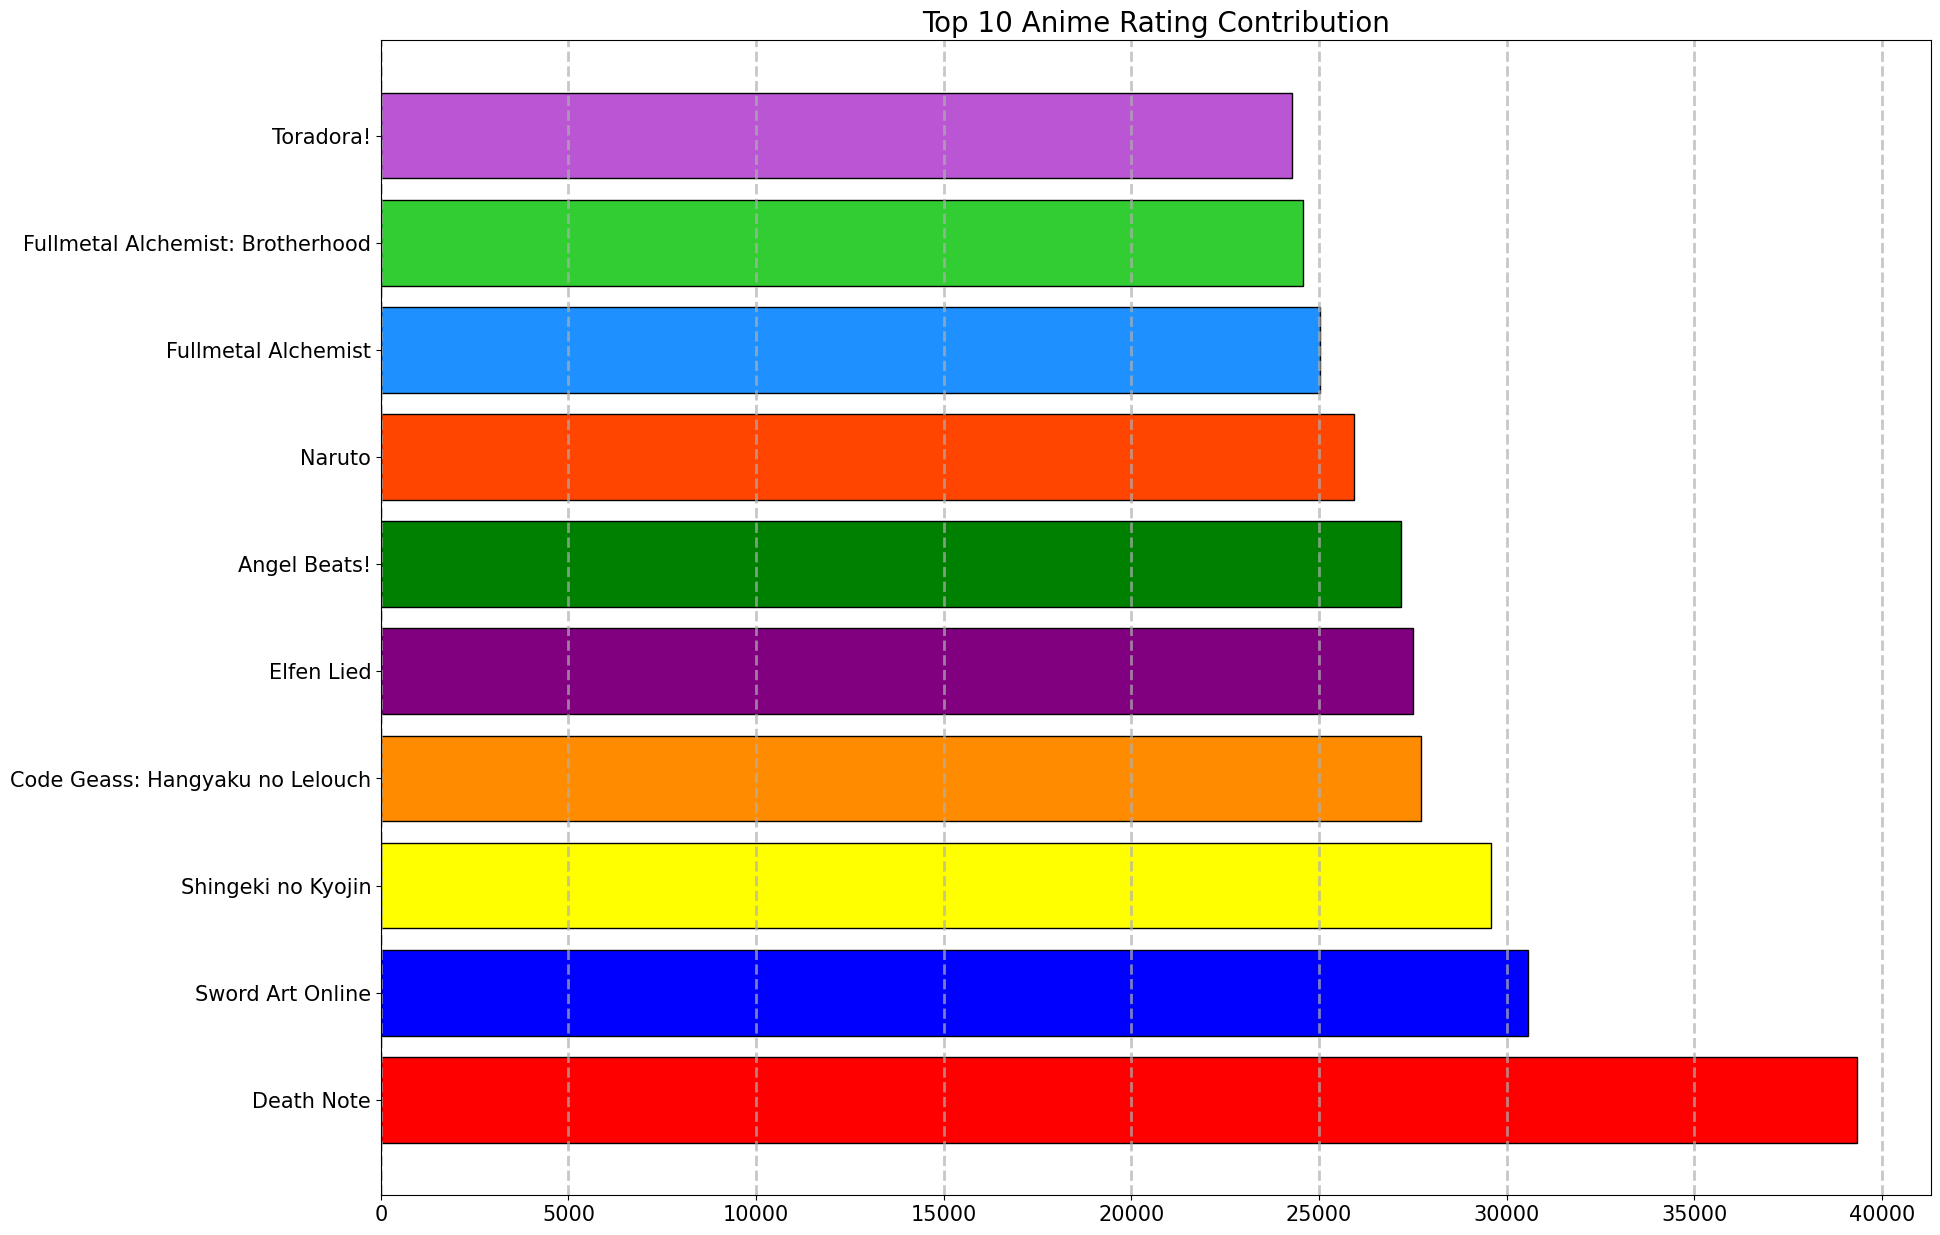

In [31]:
# Top 10 Anime Rating Contribution Plot
plt.figure(figsize = (20,15))
top10_anime = name_anime_rating_contribution[['name_y', 'rating_y']].sort_values(by = 'rating_y',ascending = False).head(10)


labels = top10_anime[['name_y']].values.flatten()
values = top10_anime[['rating_y']].values.flatten()

colors = ['#FF0000', '#0000FF', '#FFFF00', '#FF8C00', '#800080', '#008000', '#FF4500', '#1E90FF', '#32CD32', '#BA55D3'] # Define colors here

plt.barh(labels, values, color = colors, edgecolor='black')
plt.grid(linestyle='--', linewidth=2, axis='x', alpha=0.7)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Top 10 Anime Rating Contribution", fontdict = {'fontsize' : 20})
plt.show()

plt.show()

**insight**

kontribusi rating dari 10 anime teratas. Terlihat jelas bahwa "Death Note" memiliki kontribusi rating tertinggi secara signifikan, mendekati 40.000. Diikuti oleh "Sword Art Online" dan "Shingeki no Kyojin" yang juga menunjukkan kontribusi rating yang tinggi, masing-masing di atas 30.000 dan mendekati 30.000. Anime lainnya seperti "Code Geass: Hangyaku no Lelouch", "Elfen Lied", "Angel Beats!", "Naruto", "Fullmetal Alchemist", "Fullmetal Alchemist: Brotherhood", dan "Toradora!" memiliki kontribusi rating yang lebih moderat, berkisar antara 24.000 hingga 27.000. Ini menunjukkan dominasi beberapa judul anime tertentu dalam hal popularitas berdasarkan kontribusi rating.

In [32]:
# Top 10 Anime Community
anime.sort_values(by='members', ascending=False).head(10)

,anime_id,name,genre,type,episodes,rating,members
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
86,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
804,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
159,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796
19,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
445,10620,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Super...",TV,26,8.07,657190
131,4224,Toradora!,"Comedy, Romance, School, Slice of Life",TV,25,8.45,633817


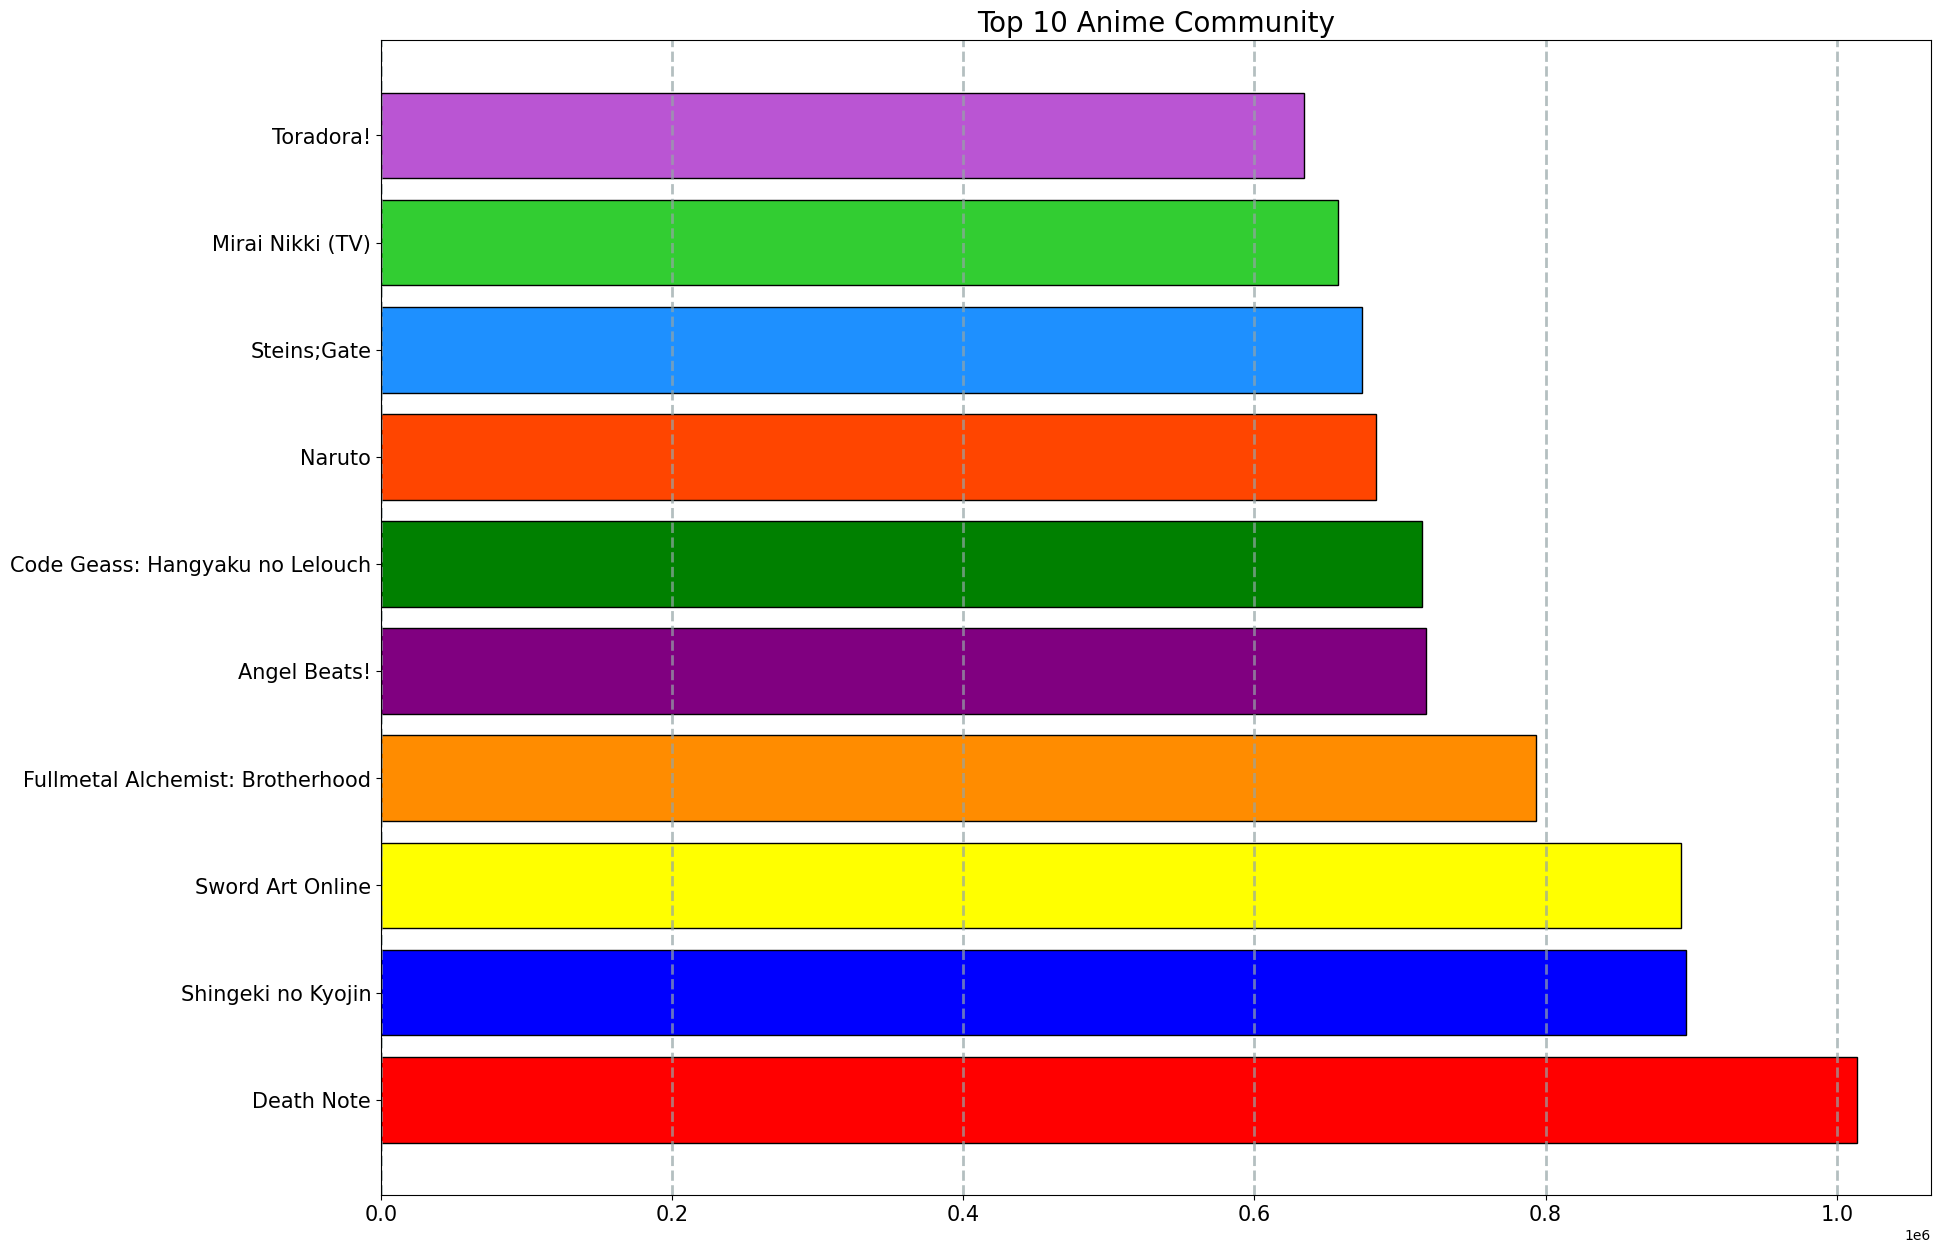

In [33]:
# Top 10 Anime Community Plot
plt.figure(figsize = (20,15))
top10_anime = anime[['name', 'members']].sort_values(by = 'members',ascending = False).head(10)

labels = top10_anime[['name']].values.flatten()
values = top10_anime[['members']].values.flatten()

plt.barh(labels, values, color = colors, edgecolor='black')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.7)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Top 10 Anime Community", fontdict = {'fontsize' : 20})
plt.show()

plt.show()

**insight**

Terlihat bahwa "Death Note" memiliki komunitas terbesar secara signifikan, mencapai hampir 1 juta. "Shingeki no Kyojin" dan "Sword Art Online" juga memiliki komunitas yang sangat besar, masing-masing melebihi 850.000 anggota. Anime lain seperti "Fullmetal Alchemist: Brotherhood" memiliki komunitas yang cukup besar, mendekati 800.000. Sementara itu, "Angel Beats!", "Code Geass: Hangyaku no Lelouch", "Naruto", "Steins;Gate", "Mirai Nikki (TV)", dan "Toradora!" memiliki ukuran komunitas yang relatif lebih kecil, namun tetap besar, dengan angka di atas 600.000. Ini menunjukkan bahwa beberapa anime memiliki basis penggemar yang sangat luas dan aktif dibandingkan dengan yang lain.

# 3. Model Development

* Content Based Filtering

TF- IDF Vectorizer melakukan inisialisasi TfidfVectorizer, kemudian perhitungan idf pada data anime dan melakukan array dari fitur index integer ke fitur nama

In [34]:
tf = TfidfVectorizer()
tf.fit(anime['genre'])
tf.get_feature_names_out()

array(['action', 'adventure', 'ai', 'arts', 'cars', 'comedy', 'dementia',
       'demons', 'drama', 'ecchi', 'fantasy', 'fi', 'game', 'harem',
       'hentai', 'historical', 'horror', 'josei', 'kids', 'life', 'magic',
       'martial', 'mecha', 'military', 'music', 'mystery', 'of', 'parody',
       'police', 'power', 'psychological', 'romance', 'samurai', 'school',
       'sci', 'seinen', 'shoujo', 'shounen', 'slice', 'space', 'sports',
       'super', 'supernatural', 'thriller', 'vampire', 'yaoi', 'yuri'],
      dtype=object)

In [35]:
tfidf_matrix = tf.fit_transform(anime['genre'])
tfidf_matrix.shape

(12017, 47)

In [36]:
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.29498527, 0.3162867 , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.2516182 , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [37]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=anime.name
).sample(22, axis=1).sample(10, axis=0)

,cars,fi,mystery,ai,harem,of,drama,psychological,demons,mecha,...,hentai,magic,romance,game,fantasy,shoujo,horror,slice,parody,music
name,,,,,,,,,,,,,,,,,,,,,
Kateikyoushi no Oneesan The Animation: H no Hensachi Agechaimasu,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
Hokuto no Ken,0.0,0.302244,0.0,0.000000,0.000000,0.000000,0.305445,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
Sinbad: Mahou no Lamp to Ugoku Shima,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
Seikimatsu Occult Gakuin Specials,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
Junjou Romantica 2,0.0,0.000000,0.0,0.716532,0.000000,0.000000,0.356781,0.0,0.0,0.0,...,0.0,0.0,0.397345,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
Kyou no 5 no 2,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
Triage X: Recollection XOXO,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
Weiß Kreuz,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.590752,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
Cherry no Manma,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.579486,0.0,0.0,0.728825,0.0,0.000000,0.0,0.0


* Menghitung cosine similarity pada matrix tf-idf

In [38]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.14715318, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14715318, 1.        , 0.17877808, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.17877808, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [39]:
cosine_df = pd.DataFrame(cosine_sim, index=anime['name'], columns=anime['name'])
print('Shape:', cosine_df.shape)
cosine_df.sample(10, axis=1).sample(10, axis=0)

Shape: (12017, 12017)


name,"Dragon Ball Z Movie 08: Moetsukiro!! Nessen, Ressen, Chougekisen",Nintama Rantarou,Magi: The Kingdom of Magic,JoJo no Kimyou na Bouken (TV),Mokkai Shiyo?,Hidamari Sketch x Honeycomb,Ishii Hisaichi no Nanda Kanda Gekijou,Shin Tenchi Muyou!,Yuyushiki,Pink Mizu Dorobou Ame Dorobou
name,,,,,,,,,,
Doraemon Movie 35: Nobita no Space Heroes,0.298219,0.548028,0.203006,0.162586,0.000000,0.087021,0.399004,0.251310,0.074729,0.374681
Maid Meshimase,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tantei Opera Milky Holmes: Summer Special,0.078115,0.143549,0.000000,0.000000,0.000000,0.073411,0.054760,0.065827,0.063042,0.098143
Juicy Jungle,0.442886,0.000000,0.000000,0.000000,0.000000,0.000000,0.310472,0.373221,0.000000,0.000000
Kuma no Minakuro to Kouhei Jiisan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ace wo Nerae! (1979),0.000000,0.000000,0.000000,0.000000,0.000000,0.205000,0.000000,0.162334,0.176044,0.000000
Nils no Fushigi na Tabi (Movie),0.453279,0.000000,0.447509,0.177019,0.000000,0.000000,0.000000,0.000000,0.000000,0.569498
Youjuu Sensen Adventure Kid,0.141599,0.000000,0.139796,0.000000,0.429932,0.000000,0.000000,0.000000,0.000000,0.177904
Bamboo Bears,0.303222,0.557222,0.000000,0.000000,0.000000,0.284965,0.212565,0.255526,0.244713,0.380967


Dataframe ini menunjukkan nilai kesamaan antar anime berdasarkan nilai cosine similarity. Semakin tinggi nilai dalam sel, semakin tinggi tingkat kesamaan antara anime pada baris dan anime pada kolom.

Misalnya, anime "Nyani ga Nyandaa Nyandaa Kamen" memiliki kesamaan yang cukup tinggi dengan "Tottoko Hamtarou Movie 1: Ham-Ham Land Daibouken" dengan nilai 0.439869, dan juga dengan "Boku wa Tomodachi ga Sukunai Episode 0" dengan nilai 0.22078. Di sisi lain, "Vocaloid China Project Senden Animation" memiliki kesamaan sempurna dengan "Navia Dratp" dengan nilai 1.0, menunjukkan kemiripan yang sangat tinggi atau bahkan duplikat data. Hal ini memungkinkan kita untuk mengidentifikasi anime yang memiliki karakteristik serupa berdasarkan data yang digunakan untuk menghitung kesamaan ini.

# Tes Model Recommendation Content Based Filtering

In [40]:
def anime_recommendations(name, similarity_data=cosine_df, items=anime[['name', 'genre']], k=5):

    index = similarity_data.loc[:,name].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop name agar nama resto yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(name, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

**insight**

Fungsi anime_recommendations ini bekerja dengan cara mengambil anime dengan similarity terbesar dari index yang ada.

In [41]:
anime[anime.name.eq('Death Note')]

,anime_id,name,genre,type,episodes,rating,members
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917


In [42]:
anime_title = 'Death Note'
anime_recommendations = anime_recommendations(anime_title)
anime_recommendations

,name,genre
0,Death Note Rewrite,"Mystery, Police, Psychological, Supernatural, ..."
1,Mousou Dairinin,"Drama, Mystery, Police, Psychological, Superna..."
2,Higurashi no Naku Koro ni Kai,"Mystery, Psychological, Supernatural, Thriller"
3,Yakushiji Ryouko no Kaiki Jikenbo,"Mystery, Police, Supernatural"
4,Imawa no Kuni no Alice (OVA),"Action, Psychological, Shounen, Supernatural, ..."


**Insight**

Sistem telah berhasil merekomendasikan top 5 persen anime yang mirip dengan "Death Note". Berarti jika Anda menyukai alur cerita yang intens, karakter yang cerdas dan kompleks, serta tema-tema psikologis yang mendalam seperti yang ada di "Death Note", Anda akan menemukan rekomendasi ini sangat cocok. Rekomendasi ini akan membuka rekomendasi ke anime lain yang menawarkan pengalaman menonton yang serupa.

---------------------------------------------------------------------------------------------------------------------------------